<a href="https://colab.research.google.com/github/Uzmamushtaque/Projects-in-Machine-Learning-and-AI/blob/main/GenerateSongLyrics1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data source

https://www.kaggle.com/datasets/elizzyliu/song-lyrics

In [1]:
import pandas as pd
import torch
from transformers import GPT2Tokenizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/all_lyrics.csv')

In [3]:
df.shape

(4000, 4)

In [4]:
df.head()

,song,artist,type,lyrics
0,Stairway to Heaven,Led Zeppelin,rock,Stairway to Heaven Lyrics[Intro]\n\n[Verse 1]\...
1,Hey Jude,Beatles,rock,Hey Jude Lyrics[Verse 1: Paul McCartney]\nHey ...
2,All Along the Watchtower,"Hendrix, Jimi",rock,"Ii. Tambourine Lyrics[Chorus, sung]\nHey, Pip,..."
3,Satisfaction,Rolling Stones,rock,"Sin título I Lyrics[Letra de ""Sin título I""]\n..."
4,Like A Rolling Stone,"Dylan, Bob",rock,Like a Rolling Stone Lyrics[Verse 1]\nOnce upo...


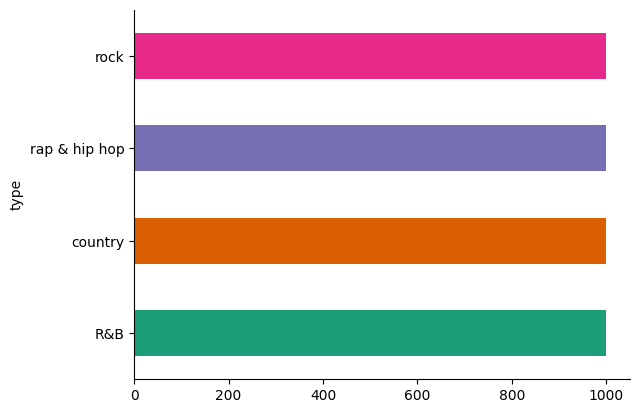

In [5]:
# @title type

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [5]:
df['lyrics'] =df['lyrics'].str.replace(r'\s+',' ',regex = True)

In [6]:
# Filter out songs that have fewer than 20 words
df['lyrics'] = df['lyrics'].astype('str')

In [7]:
# Filter out songs that have fewer than 20 words
df = df[df['lyrics'].apply(lambda x: len(x.split()) >= 20)]


In [8]:
country = df[df['type']=='country']
country.head()

,song,artist,type,lyrics
1000,I don't call him daddy,Doug Supernaw,country,I Don’t Call Him Daddy Lyrics[Verse 1] It was ...
1001,Timber I'm Falling in love,Patty Loveless,country,"Timber I’m Falling In Love LyricsRight time, t..."
1002,Picking wildflowers,Keith Anderson,country,Pickin’ Wildflowers LyricsHey baby whatcha doi...
1003,Party Crowd,David Lee Murphy,country,Party Crowd LyricsShe couldn't keep from cryin...
1004,One hell of an Amen,Brantley Gilbert,country,One Hell of an Amen Lyrics[Verse 1] Preacher s...


In [9]:
country['lyrics'] =country['lyrics'].str.replace(r'\s+',' ',regex = True)

In [10]:
country['lyrics'] = country['lyrics'].str.replace('Lyrics','')
country.head()

,song,artist,type,lyrics
1000,I don't call him daddy,Doug Supernaw,country,I Don’t Call Him Daddy [Verse 1] It was six in...
1001,Timber I'm Falling in love,Patty Loveless,country,"Timber I’m Falling In Love Right time, the rig..."
1002,Picking wildflowers,Keith Anderson,country,Pickin’ Wildflowers Hey baby whatcha doin' thi...
1003,Party Crowd,David Lee Murphy,country,Party Crowd She couldn't keep from cryin' when...
1004,One hell of an Amen,Brantley Gilbert,country,One Hell of an Amen [Verse 1] Preacher said he...


In [11]:
country['lyrics'] = country['lyrics'].str.replace('Verse','')
country['lyrics'] = country['lyrics'].str.replace('Chorus','')
country['lyrics'] = country['lyrics'].str.replace('[','')
country['lyrics'] = country['lyrics'].str.replace(']','')
country['lyrics'] = country['lyrics'].str.replace('1','')
country['lyrics'] = country['lyrics'].str.replace('2','')
country['lyrics'] = country['lyrics'].str.replace('3','')
country['lyrics'] = country['lyrics'].str.replace('4','')
country['lyrics'] = country['lyrics'].str.replace('5','')
country['lyrics'] = country['lyrics'].str.replace('6','')
country.head()


,song,artist,type,lyrics
1000,I don't call him daddy,Doug Supernaw,country,I Don’t Call Him Daddy It was six in the mor...
1001,Timber I'm Falling in love,Patty Loveless,country,"Timber I’m Falling In Love Right time, the rig..."
1002,Picking wildflowers,Keith Anderson,country,Pickin’ Wildflowers Hey baby whatcha doin' thi...
1003,Party Crowd,David Lee Murphy,country,Party Crowd She couldn't keep from cryin' when...
1004,One hell of an Amen,Brantley Gilbert,country,One Hell of an Amen Preacher said he died to...


In [12]:
country_songs = country.drop(columns = ['song','type'])
country_songs.head()

,artist,lyrics
1000,Doug Supernaw,I Don’t Call Him Daddy It was six in the mor...
1001,Patty Loveless,"Timber I’m Falling In Love Right time, the rig..."
1002,Keith Anderson,Pickin’ Wildflowers Hey baby whatcha doin' thi...
1003,David Lee Murphy,Party Crowd She couldn't keep from cryin' when...
1004,Brantley Gilbert,One Hell of an Amen Preacher said he died to...


In [13]:
#Drop the songs with longer lyrics
country_songs = country_songs[country_songs['lyrics'].apply(lambda x: len(x.split(' ')) < 300)]

print("Shape of the final songs dataset", country_songs.shape)

print(country_songs.head())

Shape of the final songs dataset (636, 2)
                artist                                             lyrics
1001    Patty Loveless  Timber I’m Falling In Love Right time, the rig...
1002    Keith Anderson  Pickin’ Wildflowers Hey baby whatcha doin' thi...
1004  Brantley Gilbert  One Hell of an Amen   Preacher said he died to...
1005    Lefty Frizzell  I Never Go Around Mirrors  : I can's stand to ...
1006     George Strait  It Ain’t Cool to Be Crazy About You   I though...


In [14]:
country_songs = country_songs.iloc[:100,:]

## Create test and training data

In [15]:
test_subset = country_songs.sample(10)
# Exclude these entries from the main dataset
country_songs = country_songs.drop(test_subset.index)

# Re-index both datasets for consistency
test_subset.reset_index(drop=True, inplace=True)
country_songs.reset_index(drop=True, inplace=True)

# In the test subset, extract the last 20 words into a new column
test_subset['Expected_Lyrics'] = test_subset['lyrics'].apply(lambda x: ' '.join(x.split()[-20:]))

# Then remove these words from the 'lyrics' column
test_subset['lyrics'] = test_subset['lyrics'].apply(lambda x: ' '.join(x.split()[:-20]))

print(len(test_subset))

test_subset.head(10)

10


,artist,lyrics,Expected_Lyrics
0,Judds,Love Can Build a Bridge I'd gladly walk across...,"Don't you think it's time? Oh, don't you think..."
1,Moe Bandy,Bandy The Rodeo Clown Who was once a bull hook...,I'm Bandy the rodeo clown And I could ride 'em...
2,Don Williams,(Turn Out the Light and) Love Me Tonight I've ...,you so now Come on let go now Kick off your sh...
3,Vince Gill / Dolly Parton,I Will Always Love You (99) If I should stay W...,will always love you I will always love you Ye...
4,George Jones,The Window Up Above I've been living a new way...,wake up to an honest love I was wrong for I wa...
5,Dixie Chicks,You Were Mine I can't find a reason to let go ...,have to take your heart away When for so long ...
6,Tim McGraw,My Little Girl Gotta hold on easy as I let you...,"home again Go on, take on this whole world But..."
7,Vince Gill,When I Call Your Name I rushed home from work ...,the tears keep fallin' But nobody answers when...
8,Mel Tillis,"Stomp Them Grapes Stomp, stomp them grapes and...","line I said stomp, stomp them grapes and make ..."
9,John Conlee,Common Man As the maid poured wine and we prep...,"say, it's gonna stay that way 'Cause high-brow..."


## Encode training data

In [16]:
# Importing the GPT2 tokenizer from the transformers library.
#The GPT2Tokenizer is a tool used to convert text into a format that can be understood by the GPT-2 model.
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Defining a function to create a dataset of lyrics for training.
def create_lyrics_dataset(lyrics, prefix_code, limit_length=990):

    # Encoding each lyric line with the tokenizer.
    encoded_lyrics = [
        torch.tensor(tokenizer.encode(f"<|{prefix_code}|>{line[:limit_length]}"))
        for line in lyrics
    ]
    return encoded_lyrics

train_subset = create_lyrics_dataset(country_songs['lyrics'], "prefix_code")


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [17]:
#train_subset

#Training the LLM

In [17]:
#Initialize a pretrained model
#Define the hyperparameters
#Setting up the optimizer and learning rate scheduler
#Training Process
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F
import os

In [18]:
# Load the tokenizer pretrained on the GPT-2 model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Load the pretrained weights of the GPT-2 model
# GPT2LMHeadModel an autoregressive model that predicts future text in a sequence based on the previous text from that very sequence.
model = GPT2LMHeadModel.from_pretrained('gpt2')

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [19]:
# Training function that will fine-tune gpt2 on our prepared dataset
def training(dataset, model, tokenizer, batch_size=8, epochs=10, learning_rate=1e-3):

    # Initialization of training parameters and setting the device
    compute_device = torch.device("cpu")
    model.to(compute_device)
    model.train()

    # Preparing the data loader for batch processing
    batch_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    current_loss, batch_accumulator = 0, 0
    processing_tensor = None

    # Setting up the optimizer and scheduler for training
    model_optimizer = AdamW(model.parameters(), lr=learning_rate)
    training_scheduler = get_linear_schedule_with_warmup(
        model_optimizer, num_warmup_steps=10, num_training_steps=-1
    )

    # Looping through each training epoch
    for current_epoch in range(epochs):
        print(f"Current training epoch: {current_epoch}")
        print(current_loss)

        # Initializing the index for while loop
        index = 0
        batch_iterator = iter(batch_loader)

        # Processing each batch in the dataset using a while loop
        while index < len(batch_loader):
            data_batch = next(batch_iterator)

            # Handling tensor packing for batch processing
            if processing_tensor is None or processing_tensor.size()[1] + data_batch.size()[1] > 500: # Max sequence limit for batches
                processing_tensor, continue_batch = (data_batch, True) if processing_tensor is None else (processing_tensor, False)
            else:
                processing_tensor = torch.cat([data_batch, processing_tensor[:, 1:]], dim=1)
                continue_batch = True

            # Skipping to next iteration if current batch should not be processed now
            if continue_batch and index != len(batch_loader) - 1:
                index += 1
                continue

            # Training model on the current batch
            processing_tensor = processing_tensor.to(compute_device)
            model_output = model(processing_tensor, labels=processing_tensor)
            current_loss = model_output[0]
            current_loss.backward()

            # Optimizer and scheduler steps
            if (batch_accumulator % batch_size) == 0:
                model_optimizer.step()
                training_scheduler.step()
                model_optimizer.zero_grad()
                model.zero_grad()

            batch_accumulator += 1
            processing_tensor = None
            index += 1

    # Saving the model state after training is complete
    torch.save(
        model.state_dict(),
        os.path.join(".", "model-final.pt"),
    )

    return model

# Training the model on the specific data we have
model = training(train_subset, model, tokenizer)

Current training epoch: 0
0
Current training epoch: 1
tensor(2.8136, grad_fn=<NllLossBackward0>)
Current training epoch: 2
tensor(3.2443, grad_fn=<NllLossBackward0>)
Current training epoch: 3
tensor(2.3206, grad_fn=<NllLossBackward0>)
Current training epoch: 4
tensor(2.3429, grad_fn=<NllLossBackward0>)
Current training epoch: 5
tensor(3.4862, grad_fn=<NllLossBackward0>)
Current training epoch: 6
tensor(2.4150, grad_fn=<NllLossBackward0>)
Current training epoch: 7
tensor(3.0307, grad_fn=<NllLossBackward0>)
Current training epoch: 8
tensor(2.7458, grad_fn=<NllLossBackward0>)
Current training epoch: 9
tensor(3.1355, grad_fn=<NllLossBackward0>)


In [20]:
def get_logits_for_next_token(model, sequence, temp_setting):
    # Generate model outputs for the given sequence
    model_outputs = model(sequence, labels=sequence)

    # Extract logits for the last token in the sequence, scale by temperature
    logits = model_outputs[1][:, -1, :] / max(temp_setting, 1.0)

    return logits

def filter_low_probability_tokens(logits, probability_threshold, filter_threshold):
    # Sort logits to find the most probable tokens and their indices
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)

    # Calculate the cumulative probabilities of the sorted logits
    cumul_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

    # Identify indices where cumulative probability exceeds the threshold
    indices_to_filter = cumul_probs > probability_threshold

    # Adjust indices to filter, ensuring the first token is not filtered out
    indices_to_filter[..., 1:] = indices_to_filter[..., :-1].clone()
    indices_to_filter[..., 0] = 0

    # Set logits of tokens to be filtered to the filter threshold
    logits[:, sorted_indices[indices_to_filter]] = filter_threshold

    return logits

In [21]:
def generate_text_for_entry(model, tokenizer, prompt, probability_threshold, temp_setting):
    # Encode the prompt into a tensor and add a batch dimension
    generated_sequence = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

    # Set a very low threshold for filtering tokens
    filter_threshold = -float("Inf")

    # Loop to generate up to 20 tokens
    for _ in range(20):
        # Obtain the logits for the next token in the sequence, scaled by temperature
        logits = get_logits_for_next_token(model, generated_sequence, temp_setting)

        # Filter out tokens with low probability to maintain text quality
        logits = filter_low_probability_tokens(logits, probability_threshold, filter_threshold)

        # Randomly select the next token based on the adjusted probabilities
        next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)

        # Concatenate the next token to the generated sequence
        generated_sequence = torch.cat((generated_sequence, next_token), dim=1)

        # Check if the next token is the end-of-sequence token; if so, break the loop
        if next_token in tokenizer.encode(""):
            break

    # Convert the generated sequence tensor into a list of integers (token IDs)
    output_sequence = list(generated_sequence.squeeze().numpy())

    # Decode the token IDs back into text and return the generated text
    return tokenizer.decode(output_sequence)




In [22]:
generated_lyrics = []

# Looping directly through the test data DataFrame
for song in range(len(test_subset)):

    # Get the prompt from the 'Lyric' column
    lyric_prompt = test_subset['lyrics'][song]

    if not lyric_prompt.strip():
        continue

    # Set the model to evaluation mode and disable gradient calculations
    model.eval()
    with torch.no_grad():
        generated_lyric = generate_text_for_entry(model.to('cpu'), tokenizer, lyric_prompt, 0.80, 1.0)

    print(generated_lyric)

    # Append the generated lyric to the list
    generated_lyrics.append(generated_lyric)

Love Can Build a Bridge I'd gladly walk across the desert With no shoes upon my feet To share with you the last bite Of bread I had to eat I would swim out to save you In your sea of broken dreams When all your hopes are sinkin' Let me show you what love means Love can build a bridge Between your heart and mine Love can build a bridge Don't you think it's time? Don't you think it's time? I would whisper love so loudly Every heart could understand That love and only love Can join the tribes of man I would give my heart's desire So that you might see The first step is to realize That it all begins with you and me Love can build a bridge Between your heart and mine Love can build a bridge Don't you think it's time? Don't you think it's time? Bridge When we stand together It's our finest hour We can do anything, anything Keep believin' in the power Love can build a bridge Between your heart and mine Love can build a bridge Don't you think it's time? Don't you think it's time? Yeah, yes I d

In [24]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=20c3a3ae26a4a7f6f121c93c7bc88cc18fd49ec40d09ac9b1a22cd8ce516c8c8
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [31]:
from rouge_score import rouge_scorer
import pandas as pd

generated_lyrics=pd.DataFrame(generated_lyrics)
generated_lyrics.to_csv('gpt2_generated_lyrics.csv')

In [32]:


# Import the lyrics dataset which contains the generated and true lyrics
lyrics_df = pd.read_csv('/content/gpt2_generated_lyrics.csv')

lyrics_df.head()


,Unnamed: 0,0
0,0,Love Can Build a Bridge I'd gladly walk across...
1,1,Bandy The Rodeo Clown Who was once a bull hook...
2,2,(Turn Out the Light and) Love Me Tonight I've ...
3,3,I Will Always Love You (99) If I should stay W...
4,4,The Window Up Above I've been living a new way...


In [41]:
# Print examples of generated and expected lyrics to understand how they differ
print("Generated:" + lyrics_df.iloc[0,1][-270:] + "\n")

print("Expected:" + test_subset['Expected_Lyrics'][0] + "\n")


Generated:Don't you think it's time? Yeah, yes I do Oh Love can build a bridge (Oh, love and only love) Between your heart and mine (Between your heart and mine) Love can build a bridge (Love and only love)  I don't know your name but I've seen it fall into my memory You know I'm

Expected:Don't you think it's time? Oh, don't you think it's time? Outro Love and only love Love and only loveEmbed



In [42]:
# Instantiate the Rouge class
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate and return average ROUGE scores between generated and expected lyrics
candidate_summary = lyrics_df.iloc[0,1][-270:]
reference_summary = test_subset['Expected_Lyrics'][0]
scores = scorer.score(reference_summary, candidate_summary)
for key in scores:
    print(f'{key}: {scores[key]}')


rouge1: Score(precision=0.31666666666666665, recall=0.7916666666666666, fmeasure=0.45238095238095233)
rouge2: Score(precision=0.2033898305084746, recall=0.5217391304347826, fmeasure=0.29268292682926833)
rougeL: Score(precision=0.25, recall=0.625, fmeasure=0.35714285714285715)


The ROUGE Score has three main components: ROUGE-N, ROUGE-L, and ROUGE-S. Each ROUGE score component offers a different perspective on the quality of the system-generated summary, considering different aspects of language and sentence structure. This is why a combination of these measures is usually used in evaluating system outputs in NLP tasks.

ROUGE-N
ROUGE-N is a component of the ROUGE score that quantifies the overlap of N-grams, contiguous sequences of N items (typically words or characters), between the system-generated summary and the reference summary. It provides insights into the precision and recall of the system's output by considering the matching N-gram sequences.

ROUGE-L
ROUGE-L, another component of the ROUGE Score, calculates the Longest Common Subsequence (LCS) between the system and reference summaries. Unlike N-grams, LCS measures the maximum sequence of words (not necessarily contiguous) that appear in both summaries. It offers a more flexible similarity measure and helps capture shared information beyond strict word-for-word matches.

ROUGE-S
ROUGE-S focuses on skip-bigrams. A skip-bigram is a pair of words in a sentence that allows for gaps or words in between. This component identifies the skip-bigram overlap between the system and reference summaries, enabling the assessment of sentence-level structure similarity. It can capture paraphrasing relationships between sentences and provide insights into the system's ability to convey information with flexible word ordering.

[source](https://thepythoncode.com/article/calculate-rouge-score-in-python#rouge-score-a-premier-evaluation-metric)